# Аналитический рекомендатель по содержанию вакансий 

Разработаем механизм рекомендаций с использованием NLTK, который поможет соискателям выбирать предпочтительную работу на основе заявок.

В процессе узнаем, как лемматизация, стемминг и векторизация используются для обработки данных и получения лучшего результата. 

Поехали!

In [1]:
#Импортируем библиотеки

import pandas as pd
import numpy as np

#Загрузим файл

final_jobs = pd.read_csv("../input/Combined_Jobs_Final.csv")

#Посмотрим первые 5 строк набора данных

final_jobs.head()

,Job.ID,Provider,Status,Slug,Title,Position,Company,City,State.Name,State.Code,...,Industry,Job.Description,Requirements,Salary,Listing.Start,Listing.End,Employment.Type,Education.Required,Created.At,Updated.At
0,111,1,open,palo-alto-ca-tacolicious-server,Server @ Tacolicious,Server,Tacolicious,Palo Alto,California,CA,...,Food and Beverages,Tacolicious' first Palo Alto store just opened...,NaN,8.00,NaN,NaN,Part-Time,NaN,2013-03-12 02:08:28 UTC,2014-08-16 15:35:36 UTC
1,113,1,open,san-francisco-ca-claude-lane-kitchen-staff-chef,Kitchen Staff/Chef @ Claude Lane,Kitchen Staff/Chef,Claude Lane,San Francisco,California,CA,...,Food and Beverages,\r\n\r\nNew French Brasserie in S.F. Financia...,NaN,0.00,NaN,NaN,Part-Time,NaN,2013-04-12 08:36:36 UTC,2014-08-16 15:35:36 UTC
2,117,1,open,san-francisco-ca-machka-restaurants-corp-barte...,Bartender @ Machka Restaurants Corp.,Bartender,Machka Restaurants Corp.,San Francisco,California,CA,...,Food and Beverages,We are a popular Mediterranean wine bar and re...,NaN,11.00,NaN,NaN,Part-Time,NaN,2013-07-16 09:34:10 UTC,2014-08-16 15:35:37 UTC
3,121,1,open,brisbane-ca-teriyaki-house-server,Server @ Teriyaki House,Server,Teriyaki House,Brisbane,California,CA,...,Food and Beverages,● Serve food/drinks to customers in a profess...,NaN,10.55,NaN,NaN,Part-Time,NaN,2013-09-04 15:40:30 UTC,2014-08-16 15:35:38 UTC
4,127,1,open,los-angeles-ca-rosa-mexicano-sunset-kitchen-st...,Kitchen Staff/Chef @ Rosa Mexicano - Sunset,Kitchen Staff/Chef,Rosa Mexicano - Sunset,Los Angeles,California,CA,...,Food and Beverages,"Located at the heart of Hollywood, we are one ...",NaN,10.55,NaN,NaN,Part-Time,NaN,2013-07-17 15:26:18 UTC,2014-08-16 15:35:40 UTC


In [2]:
# Список всех столбцов, которые присутствуют в наборе данных

list(final_jobs) 

['Job.ID',
 'Provider',
 'Status',
 'Slug',
 'Title',
 'Position',
 'Company',
 'City',
 'State.Name',
 'State.Code',
 'Address',
 'Latitude',
 'Longitude',
 'Industry',
 'Job.Description',
 'Requirements',
 'Salary',
 'Listing.Start',
 'Listing.End',
 'Employment.Type',
 'Education.Required',
 'Created.At',
 'Updated.At']

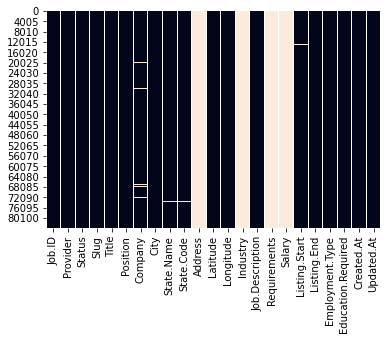

In [8]:
import seaborn as sns
sns.heatmap(final_jobs.isnull(), cbar=False); 

In [9]:
print(final_jobs.shape)
final_jobs.isnull().sum()

(84090, 23)


Job.ID                    0
Provider                  0
Status                    0
Slug                      0
Title                     0
Position                  0
Company                2271
City                    135
State.Name              171
State.Code              171
Address               84054
Latitude                  0
Longitude                 0
Industry              83823
Job.Description          56
Requirements          84090
Salary                83861
Listing.Start           683
Listing.End             167
Employment.Type          10
Education.Required      267
Created.At                0
Updated.At                0
dtype: int64

Из приведенного выше списка мы видим, что существует много значений NaN. Выполним очистку данных для каждого столбца. 

## Объединим столбцы в рабочий корпус


In [10]:
# Возьмём только необходимые для анализа столбцы
cols = list(['Job.ID']+['Slug']+['Title']+['Position']+ ['Company']+['City']+['Employment.Type']+['Education.Required']+['Job.Description'])
final_jobs =final_jobs[cols]
final_jobs.columns = ['Job.ID','Slug', 'Title', 'Position', 'Company','City', 'Empl_type','Edu_req','Job_Description']
final_jobs.head() 

,Job.ID,Slug,Title,Position,Company,City,Empl_type,Edu_req,Job_Description
0,111,palo-alto-ca-tacolicious-server,Server @ Tacolicious,Server,Tacolicious,Palo Alto,Part-Time,NaN,Tacolicious' first Palo Alto store just opened...
1,113,san-francisco-ca-claude-lane-kitchen-staff-chef,Kitchen Staff/Chef @ Claude Lane,Kitchen Staff/Chef,Claude Lane,San Francisco,Part-Time,NaN,\r\n\r\nNew French Brasserie in S.F. Financia...
2,117,san-francisco-ca-machka-restaurants-corp-barte...,Bartender @ Machka Restaurants Corp.,Bartender,Machka Restaurants Corp.,San Francisco,Part-Time,NaN,We are a popular Mediterranean wine bar and re...
3,121,brisbane-ca-teriyaki-house-server,Server @ Teriyaki House,Server,Teriyaki House,Brisbane,Part-Time,NaN,● Serve food/drinks to customers in a profess...
4,127,los-angeles-ca-rosa-mexicano-sunset-kitchen-st...,Kitchen Staff/Chef @ Rosa Mexicano - Sunset,Kitchen Staff/Chef,Rosa Mexicano - Sunset,Los Angeles,Part-Time,NaN,"Located at the heart of Hollywood, we are one ..."


In [11]:
#Проверим нулевые значения
final_jobs.isnull().sum()

Job.ID                0
Slug                  0
Title                 0
Position              0
Company            2271
City                135
Empl_type            10
Edu_req             267
Job_Description      56
dtype: int64

In [12]:
#Посмотрим пропущенные значения в колонке Город
nan_city = final_jobs[pd.isnull(final_jobs['City'])]
print(nan_city.shape)
nan_city.head()

(135, 9)


,Job.ID,Slug,Title,Position,Company,City,Empl_type,Edu_req,Job_Description
3425,142044,ga-st-francis-hospital-registered-nurse-rn-142044,Registered Nurse (RN) @ St. Francis Hospital,Registered Nurse (RN),St. Francis Hospital,NaN,Full-Time/Part-Time,Associate Degree,Under the direction of the Clinical Coordinato...
3433,142054,chi-payment-systems-sales-representative-busin...,Sales Representative - Business Development Op...,Sales Representative - Business Development Op...,CHI Payment Systems,NaN,Full-Time/Part-Time,High School Diploma,"If you&rsquo;re energetic, motivated, hardwork..."
3434,142055,chi-payment-systems-new-business-executive-142055,New Business Executive @ CHI Payment Systems,New Business Executive,CHI Payment Systems,NaN,Full-Time/Part-Time,High School Diploma,"If you&rsquo;re energetic, motivated, hardwork..."
3435,142056,chi-payment-systems-outside-sales-representati...,Outside Sales Representative (Business Develop...,Outside Sales Representative (Business Develop...,CHI Payment Systems,NaN,Full-Time/Part-Time,High School Diploma,"If you&rsquo;re energetic, motivated, hardwork..."
3436,142057,chi-payment-systems-outside-sales-representati...,Outside Sales Representative @ CHI Payment Sys...,Outside Sales Representative,CHI Payment Systems,NaN,Full-Time/Part-Time,High School Diploma,"If you&rsquo;re energetic, motivated, hardwork..."


In [13]:
nan_city.groupby(['Company'])['City'].count() 

Company
Academic Year In America                0
CBS Healthcare Services and Staffing    0
CHI Payment Systems                     0
Driveline Retail                        0
Educational Testing Services            0
Genesis Health System                   0
Genesis Health Systems                  0
Home Instead Senior Care                0
St. Francis Hospital                    0
Volvo Group                             0
Name: City, dtype: int64

Видно, что всего 9 городов компаний имеют значение NaN, поэтому вручную добавим их головные офисы, покопавшись в сети. 


In [14]:
#Заменим пропущенные значения локацией штаб-квартир

final_jobs['Company'] = final_jobs['Company'].replace(['Genesis Health Systems'], 'Genesis Health System')

final_jobs.loc[final_jobs.Company == 'CHI Payment Systems', 'City'] = 'Illinois'
final_jobs.loc[final_jobs.Company == 'Academic Year In America', 'City'] = 'Stamford'
final_jobs.loc[final_jobs.Company == 'CBS Healthcare Services and Staffing ', 'City'] = 'Urbandale'
final_jobs.loc[final_jobs.Company == 'Driveline Retail', 'City'] = 'Coppell'
final_jobs.loc[final_jobs.Company == 'Educational Testing Services', 'City'] = 'New Jersey'
final_jobs.loc[final_jobs.Company == 'Genesis Health System', 'City'] = 'Davennport'
final_jobs.loc[final_jobs.Company == 'Home Instead Senior Care', 'City'] = 'Nebraska'
final_jobs.loc[final_jobs.Company == 'St. Francis Hospital', 'City'] = 'New York'
final_jobs.loc[final_jobs.Company == 'Volvo Group', 'City'] = 'Washington'
final_jobs.loc[final_jobs.Company == 'CBS Healthcare Services and Staffing', 'City'] = 'Urbandale'

In [15]:
final_jobs.isnull().sum()

Job.ID                0
Slug                  0
Title                 0
Position              0
Company            2271
City                  0
Empl_type            10
Edu_req             267
Job_Description      56
dtype: int64

In [16]:
#Тип занятости NA от Uber, поэтому я предполагаю, что это неполный или полный рабочий день. 

nan_emp_type = final_jobs[pd.isnull(final_jobs['Empl_type'])]
print(nan_emp_type)

       Job.ID                                   Slug                   Title  \
10768  153197  san-francisco-ca-uber-driving-partner  Driving Partner @ Uber   
10769  153198    los-angeles-ca-uber-driving-partner  Driving Partner @ Uber   
10770  153199        chicago-il-uber-driving-partner  Driving Partner @ Uber   
10771  153200         boston-ma-uber-driving-partner  Driving Partner @ Uber   
10772  153201      ann-arbor-mi-uber-driving-partner  Driving Partner @ Uber   
10773  153202       oklahoma-ok-uber-driving-partner  Driving Partner @ Uber   
10774  153203          omaha-ne-uber-driving-partner  Driving Partner @ Uber   
10775  153204        lincoln-ne-uber-driving-partner  Driving Partner @ Uber   
10776  153205    minneapolis-mn-uber-driving-partner  Driving Partner @ Uber   
10777  153206        st-paul-mn-uber-driving-partner  Driving Partner @ Uber   

              Position Company           City Empl_type Edu_req  \
10768  Driving Partner    Uber  San Francisco       

In [17]:
#Заменим NA значения на "Неполный / Полный рабочий день"
final_jobs['Empl_type'] = final_jobs['Empl_type'].fillna('Full-Time/Part-Time')
final_jobs.groupby(['Empl_type'])['Company'].count()
list(final_jobs)

['Job.ID',
 'Slug',
 'Title',
 'Position',
 'Company',
 'City',
 'Empl_type',
 'Edu_req',
 'Job_Description']

#   Объединение 

#### Объединение столбцов position, company, city, empl_type и jobDesc

In [18]:
final_jobs["pos_com_city_empType_jobDesc"] = final_jobs["Position"].map(str) + " " + final_jobs["Company"] +" "+ final_jobs["City"]+ " "+final_jobs['Empl_type']+" "+final_jobs['Job_Description']
final_jobs.pos_com_city_empType_jobDesc.head()

0    Server Tacolicious Palo Alto Part-Time Tacolic...
1    Kitchen Staff/Chef Claude Lane San Francisco P...
2    Bartender Machka Restaurants Corp. San Francis...
3    Server Teriyaki House Brisbane Part-Time  ● Se...
4    Kitchen Staff/Chef Rosa Mexicano - Sunset Los ...
Name: pos_com_city_empType_jobDesc, dtype: object

In [19]:
#Удалим ненужные символы между словами, разделенными пробелами во всех столбцах, 
#чтобы сделать данные эффективными 

final_jobs['pos_com_city_empType_jobDesc'] = final_jobs['pos_com_city_empType_jobDesc'].str.replace('[^a-zA-Z \n\.]'," ")
final_jobs.pos_com_city_empType_jobDesc.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.


0    Server Tacolicious Palo Alto Part Time Tacolic...
1    Kitchen Staff Chef Claude Lane San Francisco P...
2    Bartender Machka Restaurants Corp. San Francis...
3    Server Teriyaki House Brisbane Part Time    Se...
4    Kitchen Staff Chef Rosa Mexicano   Sunset Los ...
Name: pos_com_city_empType_jobDesc, dtype: object

In [20]:
#Преобразуем все символы в нижний регистр 

final_jobs['pos_com_city_empType_jobDesc'] = final_jobs['pos_com_city_empType_jobDesc'].str.lower() 
final_jobs.pos_com_city_empType_jobDesc.head()

0    server tacolicious palo alto part time tacolic...
1    kitchen staff chef claude lane san francisco p...
2    bartender machka restaurants corp. san francis...
3    server teriyaki house brisbane part time    se...
4    kitchen staff chef rosa mexicano   sunset los ...
Name: pos_com_city_empType_jobDesc, dtype: object

In [21]:
final_all = final_jobs[['Job.ID', 'pos_com_city_empType_jobDesc']]
final_all = final_all.fillna(" ")

final_all.head()

,Job.ID,pos_com_city_empType_jobDesc
0,111,server tacolicious palo alto part time tacolic...
1,113,kitchen staff chef claude lane san francisco p...
2,117,bartender machka restaurants corp. san francis...
3,121,server teriyaki house brisbane part time se...
4,127,kitchen staff chef rosa mexicano sunset los ...


А вот и важная концепция **Стоп-слов**. 
Стоп-слова — это слова естественного языка, которые имеют очень мало значения, такие как «and», «the», «a», «an» и подобные.
Используем NLP, где NLTK (Natural Language Toolkit) используется для игнорирования слов.
Текст может содержать такие стоп-слова, как «the», «is», «are». Стоп-слова можно отфильтровать из обрабатываемого текста. Универсального списка стоп-слов в исследовании nlp не существует, однако модуль nltk содержит список стоп-слов. 

Следующий используемый здесь пакет — это стемминг. Идея стемминга — это своего рода метод нормализации. Многие варианты слов несут одно и то же значение, кроме случаев, когда используется время. Итак, чтобы очистить пространство, мы используем метод стемминга, и один из используемых здесь пакетов — PorterStemmer. 

In [22]:
print(final_all.head(1))

   Job.ID                       pos_com_city_empType_jobDesc
0     111  server tacolicious palo alto part time tacolic...


 Импортируем стоп-слова из nltk.corpus.
  ##  NLTK - это аббревиатура от Natural Language Toolkit. 
Удаляет такие стоп-слова: the, is, and etc..

In [23]:
pos_com_city_empType_jobDesc = final_all['pos_com_city_empType_jobDesc']

#Удаление стоп-слов и применение PorterStemmer 

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
stemmer =  PorterStemmer()
stop = stopwords.words('english')
only_text = pos_com_city_empType_jobDesc.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
only_text.head()


0    server tacolicious palo alto part time tacolic...
1    kitchen staff chef claude lane san francisco p...
2    bartender machka restaurants corp. san francis...
3    server teriyaki house brisbane part time serve...
4    kitchen staff chef rosa mexicano sunset los an...
Name: pos_com_city_empType_jobDesc, dtype: object

Разбиение каждого слова на строку через пробел. 

In [24]:
only_text = only_text.apply(lambda x : filter(None,x.split(" ")))
print(only_text.head())

0    <filter object at 0x7f81599286d0>
1    <filter object at 0x7f8159909a10>
2    <filter object at 0x7f815992c1d0>
3    <filter object at 0x7f815992c8d0>
4    <filter object at 0x7f815991e250>
Name: pos_com_city_empType_jobDesc, dtype: object


Здесь **стемминг** в основном используется для удаления суффиксов и общих слов, которые повторяются и разделяются запятыми. for y in x означает для каждого слова (y) в общем списке (x) 

In [25]:
only_text = only_text.apply(lambda x : [stemmer.stem(y) for y in x])
print(only_text.head())

0    [server, tacolici, palo, alto, part, time, tac...
1    [kitchen, staff, chef, claud, lane, san, franc...
2    [bartend, machka, restaur, corp., san, francis...
3    [server, teriyaki, hous, brisban, part, time, ...
4    [kitchen, staff, chef, rosa, mexicano, sunset,...
Name: pos_com_city_empType_jobDesc, dtype: object


В приведенном выше коде мы разделили каждую букву в слове через запятую, теперь на этом шаге мы соединяем слова (x) 


In [26]:
only_text = only_text.apply(lambda x : " ".join(x))
print(only_text.head())

0    server tacolici palo alto part time tacolici f...
1    kitchen staff chef claud lane san francisco pa...
2    bartend machka restaur corp. san francisco par...
3    server teriyaki hous brisban part time serv fo...
4    kitchen staff chef rosa mexicano sunset lo ang...
Name: pos_com_city_empType_jobDesc, dtype: object


In [27]:
#Добавление избранного столбца обратно в pandas

final_all['text']= only_text

#Поскольку добавили новый столбец, выполнив все операции с использованием лямбда-функции, 
#удалим ненужный столбец 

final_all = final_all.drop("pos_com_city_empType_jobDesc", 1)

list(final_all)
final_all.head()

,Job.ID,text
0,111,server tacolici palo alto part time tacolici f...
1,113,kitchen staff chef claud lane san francisco pa...
2,117,bartend machka restaur corp. san francisco par...
3,121,server teriyaki hous brisban part time serv fo...
4,127,kitchen staff chef rosa mexicano sunset lo ang...


In [ ]:
#сохранить этот файл для резервного копирования 
#final_all.to_csv("job_data.csv", index=True)

# TF-IDF (Term Frequency - Inverse Document Frequency) 
Этот метод также называется нормализацией.
TF — сколько раз конкретное слово встречается в одном документе.
IDF — уменьшает масштаб слов, которые часто встречаются в документах. 

In [28]:
#Инициализация tfidf векторизатора

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

tfidf_vectorizer = TfidfVectorizer()

tfidf_jobid = tfidf_vectorizer.fit_transform((final_all['text'])) #подгонка и преобразование вектора 
tfidf_jobid

<84090x49363 sparse matrix of type '<class 'numpy.float64'>'
	with 8260550 stored elements in Compressed Sparse Row format>

# Корпус запросов пользователей
Возьмём другой набор данных, который называется Job_Views

In [29]:
#Рассмотрим новый набор данных и примем во внимание наборов данных job_view 
#интересуют: должность, опыт кандидата для создания запроса, который подал заявку на работу

job_view = pd.read_csv("../input/Job_Views.csv")
job_view.head()


,Applicant.ID,Job.ID,Title,Position,Company,City,State.Name,State.Code,Industry,View.Start,View.End,View.Duration,Created.At,Updated.At
0,10000,73666,Cashiers & Valets Needed! @ WallyPark,Cashiers & Valets Needed!,WallyPark,Newark,New Jersey,NJ,NaN,2014-12-12 20:12:35 UTC,2014-12-12 20:31:24 UTC,1129.0,2014-12-12 20:12:35 UTC,2014-12-12 20:12:35 UTC
1,10000,96655,Macy's Seasonal Retail Fragrance Cashier - Ga...,Macy's Seasonal Retail Fragrance Cashier - Ga...,Macy's,Garden City,New York,NY,NaN,2014-12-12 20:08:50 UTC,2014-12-12 20:10:15 UTC,84.0,2014-12-12 20:08:50 UTC,2014-12-12 20:08:50 UTC
2,10001,84141,Part Time Showroom Sales / Cashier @ Grizzly I...,Part Time Showroom Sales / Cashier,Grizzly Industrial Inc.,Bellingham,Washington,WA,NaN,2014-12-12 20:12:32 UTC,2014-12-12 20:17:18 UTC,286.0,2014-12-12 20:12:32 UTC,2014-12-12 20:12:32 UTC
3,10002,77989,Event Specialist Part Time @ Advantage Sales &...,Event Specialist Part Time,Advantage Sales & Marketing,Simpsonville,South Carolina,SC,NaN,2014-12-12 20:39:23 UTC,2014-12-12 20:42:13 UTC,170.0,2014-12-12 20:39:23 UTC,2014-12-12 20:39:23 UTC
4,10002,69568,Bonefish - Kitchen Staff @ Bonefish Grill,Bonefish - Kitchen Staff,Bonefish Grill,Greenville,South Carolina,SC,NaN,2014-12-12 20:43:25 UTC,2014-12-12 20:43:58 UTC,33.0,2014-12-12 20:43:25 UTC,2014-12-12 20:43:25 UTC


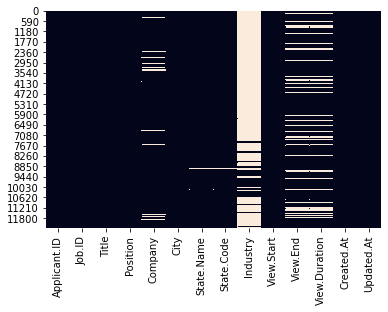

In [30]:
sns.heatmap(job_view.isnull(), cbar=False);

In [31]:
#Подмножество только необходимых столбцов, без учёта ненужных

job_view = job_view[['Applicant.ID', 'Job.ID', 'Position', 'Company','City']]

job_view["pos_com_city"] = job_view["Position"].map(str) + "  " + job_view["Company"] +"  "+ job_view["City"]

job_view['pos_com_city'] = job_view['pos_com_city'].str.replace('[^a-zA-Z \n\.]',"")

job_view['pos_com_city'] = job_view['pos_com_city'].str.lower()

job_view = job_view[['Applicant.ID','pos_com_city']]

job_view.head()


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  import sys


,Applicant.ID,pos_com_city
0,10000,cashiers valets needed wallypark newark
1,10000,macys seasonal retail fragrance cashier gard...
2,10001,part time showroom sales cashier grizzly ind...
3,10002,event specialist part time advantage sales m...
4,10002,bonefish kitchen staff bonefish grill green...


### Experience
Возьмём опыт всех соискателей, подавших заявки на вакансию, и сравниваем интересующие нас места с вакансиями, которые присутствовали в наших предыдущих данных. 

In [32]:
#Experience
exper_applicant = pd.read_csv("../input/Experience.csv")
exper_applicant.head()

,Applicant.ID,Position.Name,Employer.Name,City,State.Name,State.Code,Start.Date,End.Date,Job.Description,Salary,Can.Contact.Employer,Created.At,Updated.At
0,10001,Account Manager / Sales Administration / Quali...,Barcode Resourcing,Bellingham,Washington,WA,2012-10-15,NaN,NaN,NaN,NaN,2014-12-12 20:10:02 UTC,2014-12-12 20:10:02 UTC
1,10001,Electronics Technician / Item Master Controller,Ryzex Group,Bellingham,Washington,WA,2001-12-01,2012-04-01,NaN,NaN,NaN,2014-12-12 20:10:02 UTC,2014-12-12 20:10:02 UTC
2,10001,Machine Operator,comptec inc,Custer,Washington,WA,1997-01-01,1999-01-01,NaN,NaN,NaN,2014-12-12 20:10:02 UTC,2014-12-12 20:10:02 UTC
3,10003,maintenance technician,Winn residental,washington,District of Columbia,DC,NaN,NaN,"Necessary maintenance for ""Make Ready"" Plumbin...",10.0,False,2014-12-12 21:27:05 UTC,2014-12-12 21:27:05 UTC
4,10003,Electrical Helper,michael and son services,alexandria,Virginia,VA,NaN,NaN,repair and services of electrical construction,NaN,False,2014-12-12 21:27:05 UTC,2014-12-12 21:27:05 UTC


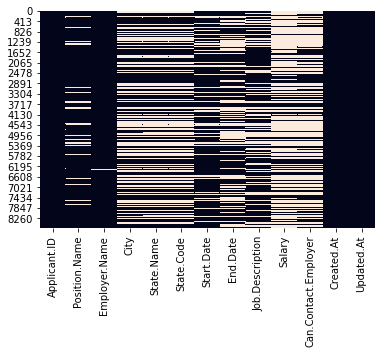

In [33]:
sns.heatmap(exper_applicant.isnull(), cbar=False);

In [34]:
#Возьмём только Position

exper_applicant = exper_applicant[['Applicant.ID','Position.Name']]

#Почистим текст

exper_applicant['Position.Name'] = exper_applicant['Position.Name'].str.replace('[^a-zA-Z \n\.]',"")

exper_applicant.head()
list(exper_applicant)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  import sys


['Applicant.ID', 'Position.Name']

In [35]:
exper_applicant['Position.Name'] = exper_applicant['Position.Name'].str.lower()
exper_applicant.head(10)

,Applicant.ID,Position.Name
0,10001,account manager sales administration quality...
1,10001,electronics technician item master controller
2,10001,machine operator
3,10003,maintenance technician
4,10003,electrical helper
5,10003,technician
6,10004,NaN
7,10004,NaN
8,10004,shift superviveur
9,10005,all star houseman


In [36]:
exper_applicant =  exper_applicant.sort_values(by='Applicant.ID')
exper_applicant = exper_applicant.fillna(" ")
exper_applicant.head(20)


,Applicant.ID,Position.Name
2763,2,volunteer
2762,2,writer for the uloop blog
3759,3,marketing intern
3758,3,server
3757,3,prep cook
6277,6,project assistant
7490,8,deli clerkserver cashier food prep order taker
368,11,cashier
809,12,server
810,12,rec leader


Для applicant_id 10001 описание должности отображается как Nan в первых трех строках, поэтому эти наблюдения будут удалены, и не будут учитываться в наборе данных.

In [37]:
#Добавим одинаковые строки в одну

exper_applicant = exper_applicant.groupby('Applicant.ID', sort=False)['Position.Name'].apply(' '.join).reset_index()
exper_applicant.head(20)

,Applicant.ID,Position.Name
0,2,volunteer writer for the uloop blog
1,3,marketing intern server prep cook
2,6,project assistant
3,8,deli clerkserver cashier food prep order taker
4,11,cashier
5,12,server rec leader it program management intern
6,13,offica assistant cashier assistant
7,14,waitress host lifeguard
8,15,
9,18,baristacashier server receptionist


### Position of Interest

In [38]:
#Position of interest

poi =  pd.read_csv("../input/Positions_Of_Interest.csv", sep=',')
poi = poi.sort_values(by='Applicant.ID')
poi.head()

,Applicant.ID,Position.Of.Interest,Created.At,Updated.At
6437,96,Server,2014-08-14 15:56:42 UTC,2015-02-26 20:35:12 UTC
1156,153,Barista,2014-08-14 15:56:43 UTC,2015-02-18 02:35:06 UTC
1155,153,Host,2014-08-14 15:56:42 UTC,2015-02-26 20:35:12 UTC
1154,153,Server,2014-08-14 15:56:42 UTC,2015-02-26 20:35:12 UTC
1158,153,Sales Rep,2014-08-14 15:56:47 UTC,2015-03-02 02:13:08 UTC


In [ ]:
sns.heatmap(poi.isnull(), cbar=False);

In [ ]:
# Нет необходимости в создании и обновлении, т.к. 
# у нас нет дедлайна, поэтому отбросим ненужное

poi = poi.drop('Updated.At', 1)
poi = poi.drop('Created.At', 1)

#Почистим текст

poi['Position.Of.Interest'] = poi['Position.Of.Interest'].str.replace('[^a-zA-z \n\.]',"")
poi['Position.Of.Interest'] = poi['Position.Of.Interest'].str.lower()
poi = poi.fillna(" ")
poi.head(20)

In [ ]:
poi = poi.groupby('Applicant.ID', sort=True)['Position.Of.Interest'].apply(' '.join).reset_index()
poi.head()

### Слияние

In [ ]:
#Сольём jobs и experience 

out_joint_jobs = job_view.merge(exper_applicant, left_on='Applicant.ID', right_on='Applicant.ID', how='outer')
print(out_joint_jobs.shape)
out_joint_jobs = out_joint_jobs.fillna(' ')
out_joint_jobs = out_joint_jobs.sort_values(by='Applicant.ID')
out_joint_jobs.head()

In [ ]:
#Сольём position of interest с существующим датафреймом

joint_poi_exper_view = out_joint_jobs.merge(poi, left_on='Applicant.ID', right_on='Applicant.ID', how='outer')
joint_poi_exper_view = joint_poi_exper_view.fillna(' ')
joint_poi_exper_view = joint_poi_exper_view.sort_values(by='Applicant.ID')
joint_poi_exper_view.head()

In [ ]:
#Объединим все столбцы

joint_poi_exper_view["pos_com_city1"] = joint_poi_exper_view["pos_com_city"].map(str) + joint_poi_exper_view["Position.Name"] +" "+ joint_poi_exper_view["Position.Of.Interest"]

joint_poi_exper_view.head()

In [ ]:
final_poi_exper_view = joint_poi_exper_view[['Applicant.ID','pos_com_city1']]
final_poi_exper_view.head()

In [ ]:
final_poi_exper_view.columns = ['Applicant_id','pos_com_city1']
final_poi_exper_view.head()

In [ ]:
final_poi_exper_view = final_poi_exper_view.sort_values(by='Applicant_id')
final_poi_exper_view.head()

In [ ]:
final_poi_exper_view['pos_com_city1'] = final_poi_exper_view['pos_com_city1'].str.replace('[^a-zA-Z \n\.]',"")
final_poi_exper_view.head()


In [ ]:
final_poi_exper_view['pos_com_city1'] = final_poi_exper_view['pos_com_city1'].str.lower()
final_poi_exper_view.head()

In [ ]:
final_poi_exper_view = final_poi_exper_view.reset_index(drop=True)
final_poi_exper_view.head()

Возьмём рандомную строку

In [ ]:
#Берём пользователя
u = 6945
index = np.where(final_poi_exper_view['Applicant_id'] == u)[0][0]
user_q = final_poi_exper_view.iloc[[index]]
user_q

# Используем модель векторного пространства (косинусное подобие)
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html

**Теория**

Нам нужно найти какое-то сходство между описанием должности и набором резюме. 
Косинусное сходство между выборками по X и Y: вычисляет подобие как нормализованное скалярное произведение X и Y:

     K (X, Y) = <X, Y> / (|| X || * || Y ||)
Результатом является косинусное подобие, которое инвариантно к масштабированию и ограничивает значение от -1 до 1. Значение косинуса 0 означает, что два вектора расположены под углом 90 градусов друг к другу (ортогональны) и не имеют совпадений. Чем ближе значение косинуса к 1, тем меньше угол и больше совпадение между векторами. 
В общем, cos θ указывает на подобие с точки зрения направления векторов. Это остается в силе по мере увеличения числа измерений, следовательно, cos θ является полезной мерой в многомерном пространстве. 

In [ ]:
#Создание tf-idf запроса соискателя и вычисление его косинусного сходства с работой 

from sklearn.metrics.pairwise import cosine_similarity
user_tfidf = tfidf_vectorizer.transform(user_q['pos_com_city1'])
output = map(lambda x: cosine_similarity(user_tfidf, x),tfidf_jobid)


In [ ]:
output2 = list(output)

In [ ]:
#Берём job id's из рекоммендаций

top = sorted(range(len(output2)), key=lambda i: output2[i], reverse=True)[:50]
recommendation = pd.DataFrame(columns = ['ApplicantID', 'JobID'])

count = 0
for i in top:
    recommendation.at[count, 'ApplicantID'] = u
    recommendation.at[count,'JobID'] = final_all['Job.ID'][i]
    count += 1

****Оценка косинусного сходства****

In [ ]:
recommendation

In [ ]:
#Получение job id's и их данных

nearestjobs = recommendation['JobID']
job_description = pd.DataFrame(columns = ['JobID','text'])
for i in nearestjobs:
    index = np.where(final_all['Job.ID'] == i)[0][0]    
    job_description.at[count, 'JobID'] = i
    job_description.at[count, 'text'] = final_all['text'][index]
    count += 1

In [ ]:
#Выведем работу, соответствующую запросам

job_description

In [ ]:
job_description.to_csv("recommended_content.csv")

In [ ]:
final_all.to_csv("job_data.csv", index=False)